# A simple genetic algorithm implementation

The code below shows a simple genetic algorithm implementation in python, using a single bitstring for finding the maximum of a one-dimensional fitness function

In [1]:
import numpy as np
import random as rnd
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Some helper functions

We need to convert between a binary and a decimal representation of the individuals many times. Thus, som simple helper functions for this conversion is implemented

In [2]:
# Takes a bitstring (of any length) and converts it to a decimal
def bin2dec(s):
    lst = list(s)
    return np.sum([int(lst[i])*2**(len(lst)-i-1) for i in range(len(lst))])

In [3]:
# Takes a decimal, and converts it to a bitstring of length n
def dec2bin(i,n):
    s = [x for x in range(n)]
    for j in range(n):
        s[j] = int(i/2**(len(s)-j-1))
        i = i-s[j]*(2**(len(s)-j-1))        
    return ''.join([str(e) for e in s])

## The fitness function to be optimized

This is the function to be optimized. It takes a single variable, and simply returns the fitness. The function is plotted below

In [4]:
def fitness(x):
    return 240*x - x**2

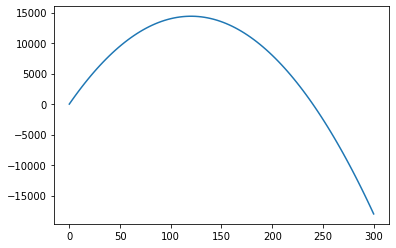

In [5]:
x = np.linspace(0, 300, 100)
y = fitness(x)
plt.plot(x, y)

## The GA Selection function

The selection function takes a population as input, and returns a selection from this population biased towards individuals with a high fitness value. Highly fit individuals will typically be represented many times in the new selection

In [21]:
def selection(pop):
    scaleParam = 1.0
    pop_d = [bin2dec(x) for x in pop]
        
    # Select the fittest individuals in the population for mating 
    ft = [fitness(x) for x in pop_d] #Calculate fitness
    ftmin = np.min(ft)                                     # Minimum fitness value for scaling
    ft = [ft[x]-int(scaleParam*ftmin) for x in range(0,len(ft))]           # Scale fitness values
    ftsum = np.sum(ft)                                     # Sum of all fitness values
    ftave = np.average(ft)

    fitshare = [(fitness(x)-scaleParam*ftmin)/ftsum for x in pop_d]   # Calculate relative share of fitness for each individual
    fit_aggr_share = [np.sum(fitshare[0:x]) for x in range(0,len(fitshare))]
    
    # Select by drawing a random number, and choose corresponding individual (spinning wheel)
    selPop = [pop[np.searchsorted(fit_aggr_share,rnd.random())-1] for x in ft]
    selPop_d = [bin2dec(x) for x in selPop]
    ftSel = [fitness(x) for x in selPop_d] #Calculate fitness

    # Creating a dataframe for reporting from each generation
    df = pd.DataFrame(pop, columns=['Ind'])
    df['Decimal'] = pop_d
    df['Fitness'] = [fitness(x) for x in pop_d]
    df['Scaled'] = ft
    df['Share'] = fitshare
    df['Aggr'] = fit_aggr_share
    df['SelPop'] = selPop
    df['SelPopDec'] = selPop_d
    df['selFitness'] = ftSel
        
    return selPop, df

## The GA Crossover function

The crossover function takes pairs of individuals from the populations, (in the mate() function) splits the bitstring in two at an arbitrary point, and switches one part between the individuals

In [22]:
# Receives two individuals, splits at the random position x, and switches bitstring material
def mate(i1,i2):
    x = rnd.randint(1,len(i1)-1)
    i1new = i1[0:x] + i2[x:len(i2)]
    i2new = i2[0:x] + i1[x:len(i1)]

    return i1new,i2new,x

In [23]:
def crossover(pop, df):
    # The next line creates pairs of offsprings
    newPop = [[x[0],x[1]] for x in [mate(pop[i], pop[i+1]) for i in range(0,len(pop)-1,2)]]
    # We need to flatten the pair list to a single list
    newPop = [x for y in newPop for x in y]

    df['Before'] = pop
    df['Crossed'] = newPop
    df['Values'] = [bin2dec(x) for x in newPop]
    df['Fx'] = [fitness(y) for y in [bin2dec(x) for x in newPop]]

    return newPop, df

## The GA Mutation function

The mutation function selects random individuals in the population (with probability prob)  and flips the bit at an arbitrary point in the string

In [24]:
def flipBit(x):
    pos = rnd.randint(0,len(x)-1)
    new = '1' if x[pos]=='0' else '0'
    x = x[:pos] + new + x[pos+1:]
    return x
    
def mutate(pop, prob, verbose=False):
    pop = [flipBit(x) if (rnd.random()<prob) else x for x in pop]
    return pop

## Creating successive generations towards an optimal solution

In [25]:
def state(pop):
    pop_d = [bin2dec(x) for x in pop]
    avg_fitness = np.average([fitness(x) for x in pop_d])
    best_val = np.amax([fitness(x) for x in pop_d])
    best_ind = pop_d[np.argmax([fitness(x) for x in pop_d])]
    return pop, avg_fitness, best_ind, best_val

In [26]:
def ga_iterate(pop, printIter=False):
    pop, df = selection(pop)
    pop, df = crossover(pop, df)
    pop = mutate(pop, 0.3)
    df['AfterMut'] = [bin2dec(x) for x in pop]
    df['ValAfterMut'] = [fitness(y) for y in [bin2dec(x) for x in pop]]
    
    # Print the dataframe for each iteration if printIter is True
    if printIter:
        print(df)

    return state(pop)

    BestInd  BestValue           Avg  SavedBest
0     117.0    14391.0  10917.966667      117.0
1     118.0    14396.0  11584.900000      118.0
2     122.0    14396.0  10040.300000      122.0
3     115.0    14375.0  12162.266667      122.0
4     115.0    14375.0  12671.633333      122.0
5     115.0    14375.0  11650.566667      122.0
6     115.0    14375.0  12207.000000      122.0
7     115.0    14375.0  12573.933333      122.0
8     115.0    14375.0  13086.900000      122.0
9     120.0    14400.0  13250.700000      120.0
10    120.0    14400.0  13331.200000      120.0
11    120.0    14400.0  12498.833333      120.0
12    119.0    14399.0  13261.933333      120.0
13    119.0    14399.0  12457.966667      120.0
14    119.0    14399.0  12730.800000      120.0
15    120.0    14400.0  13622.066667      120.0
16    120.0    14400.0  13699.666667      120.0
17    120.0    14400.0  13817.200000      120.0
18    120.0    14400.0  13915.666667      120.0
19    120.0    14400.0  13676.133333    

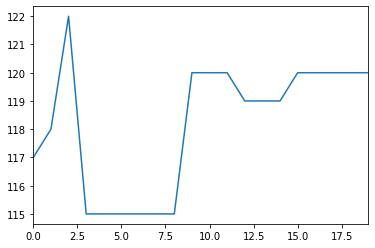

In [32]:
pop_d = [rnd.randint(0,200) for i in range(30)]
pop_b = [dec2bin(x,8) for x in pop_d]
dfRes = pd.DataFrame(columns=['BestInd', 'BestValue', 'Avg', 'SavedBest'])
savedBest = 0
for i in range(20):
    #print('ITERATION ' + str(i) + ':')
    pop_b, avg, best_ind, best_val = ga_iterate(pop_b, printIter=False)
    savedBest = best_ind if best_val >= fitness(savedBest) else savedBest 
    dfRes = dfRes.append({'BestInd': best_ind, 'BestValue' : best_val , 'Avg' : avg, 'SavedBest' : savedBest} , ignore_index=True)
    
print(dfRes)
dfRes['BestInd'].plot()